In [1]:
from ABM_MeanField_Cells.utils import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from utils_gent_measure import *
import networkx as nx
import matplotlib.gridspec as gridspec
import math
np.set_printoptions(linewidth=400)
%matplotlib inline

import os
#set a nice seaborn style

pd.options.mode.chained_assignment = None

sns.set()
sns.set(rc={'figure.figsize':(16,9)})
sns.set_style("whitegrid")
sns.set_context("talk")

#ignore FutureWarning
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)





/home/gmauro/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
starting_deployment = "centre_segr"
num_agents = 2**12

directory = f"out/batch_results/{starting_deployment}/{num_agents}agents"
intermediate_dir = os.path.join(directory, "intermediate")
exp_directory = os.path.join(directory, "exps")

out_plot_directory = os.path.join("out/plots", starting_deployment)
os.makedirs(out_plot_directory, exist_ok=True)

out_plot_directory


'out/plots/centre_segr'

In [ ]:
if "big" in starting_deployment:
    width = height = 9
else:
    width = height = 7


import colorcet as cc
palette = sns.color_palette(cc.glasbey, n_colors=width*height)

# Picking one

In [3]:
# List of p_g values
p_g = 0.1
p_g_str = f"pg_{p_g}_"
h=20
h_str = f"h_{h}_"
delta = 15
delta_str = f"delta_{delta}_"
rep = 18
rep_str = f"rep_{rep}_"

# Construct filenames
chi_hat_filename = f"{p_g_str}{h_str}{rep_str}{delta_str}results_chi_hat.csv"
gamma_filename = f"{p_g_str}{h_str}{rep_str}{delta_str}results_net_avg_prod.csv"
chi_filename = f"{p_g_str}{h_str}{rep_str}{delta_str}results_chi.csv"
exec_model_filename = f"{p_g_str}{h_str}{rep_str}results_model.csv"
exec_agents_filename = f"{p_g_str}{h_str}{rep_str}results_agents.csv"

df_chi_hat = pd.read_csv(os.path.join(intermediate_dir, chi_hat_filename), index_col=0)
df_gamma = pd.read_csv(os.path.join(intermediate_dir, gamma_filename), index_col=0)
df_chi = pd.read_csv(os.path.join(intermediate_dir, chi_filename), index_col=0)
df_exec_model = pd.read_csv(os.path.join(exp_directory, exec_model_filename), index_col=0)

cells2times= {}
for cell in df_chi_hat.columns:

    peaks = find_shifts(df_chi_hat[cell].reset_index(drop=True))
    if len(peaks) == 0:
        time = 0
    else:
        time = peaks[0]
    

    cells2times[cell] = time

#substitute the nan values with 0 in cells2times
cells2times = {key: 0 if np.isnan(value) else value for key, value in cells2times.items()}



dict_times_gamma = {}
for cell in df_gamma.columns:

    peaks_gamma = find_peaks_custom(df_gamma[cell].reset_index(drop=True))

    if len(peaks_gamma) == 0:
        max_gamma = 0
    else:
        max_gamma = peaks_gamma[0]

    dict_times_gamma[cell] = max_gamma



In [4]:
df_times_gamma = pd.DataFrame.from_dict(dict_times_gamma, orient="index", columns=["time_gamma"])
df_times_cells = pd.DataFrame.from_dict(cells2times, orient="index", columns=["time_chi_hat"])

df_times = pd.concat([df_times_gamma, df_times_cells], axis=1)
df_times.fillna(0, inplace=True)



In [5]:

#from chi_hat_filename, remove the part after the REP
df = read_df_agents(os.path.join(exp_directory, exec_agents_filename))


mass = range(df["pos"].max()[0] + 1)
num_steps = max(df["Step"])
all_sources = [(o, d) for o in mass for d in mass]

df_edges = df[df["source"] != df["pos"]].reset_index(drop=True)
df_edges_A, df_edges_B, df_edges_C = get_df_edges(df_edges)

df_flow_A = get_df_flows(df_edges_A)
df_flow_B = get_df_flows(df_edges_B)
df_flow_C = get_df_flows(df_edges_C)


df_cell_median = get_median_richness_df(df_exec_model, all_sources)


In [6]:
def min_column_with_special_handling(row):
    # Check if one of the first two columns is 0 and the other is not
    if (row[0] == 0 and row[1] != 0): #if gamma never peaks and chi_hat peaks
        return "FN"
    elif (row[1] == 0 and row[0] != 0): #if chi_hat never peaks and gamma peaks
        return "FP"
    elif (row[0] == 0 and row[1] == 0): #if both never peak
        return "TN"
    else:
        min_val = row[:2].min()
        min_columns = row[:2][row[:2] == min_val].index.tolist()
        return min_columns[0]


#df_times["min"] = df_times.idxmin(axis=1)
df_times["min"] = df_times.apply(min_column_with_special_handling, axis=1)

df_times

,time_gamma,time_chi_hat,min
"(0, 0)",32,39,time_gamma
"(0, 1)",25,32,time_gamma
"(0, 2)",0,0,TN
"(0, 3)",22,32,time_gamma
"(0, 4)",61,70,time_gamma
"(0, 5)",119,126,time_gamma
"(0, 6)",22,32,time_gamma
"(1, 0)",22,31,time_gamma
"(1, 1)",0,0,TN
"(1, 2)",0,0,TN


In [ ]:
#Cherry picking
row_of_interest = "(2, 4)"


df_cell_gini = get_gini_richness_df(df_exec_model, all_sources)
df_cell_median = get_median_richness_df(df_exec_model, all_sources)


first_peak = find_peaks_custom(df_gamma[row_of_interest].reset_index(drop=True))[0]
print(first_peak)



123


In [8]:
def plot_cherry_picking(ax, df_chi, df_chi_hat, df_gamma, row_of_interest, linewidth=1, markersize=2.5):
    # Plot chi_hat
    sns.lineplot(ax=ax, data=df_chi_hat[row_of_interest].reset_index(drop=True), legend=True,
                 linewidth=linewidth, dashes=False, label=r"$\mathcal{G}_{bin}$", marker="s", 
                 color='#2A2E34', markersize=markersize, markeredgewidth = 0.55)

    # Plot gamma
    sns.lineplot(ax=ax, data=df_gamma[row_of_interest].reset_index(drop=True), legend=True,
                 linewidth=linewidth, dashes=False, label=r"$\mathcal{G}_{net}$", marker="o", 
                 color='#eeba2c', markersize=markersize, markeredgewidth = 0.55)

    # Remove right and top spines
    sns.despine(ax=ax)

    # Set grid alpha (reduce line thickness for smaller plot)
    ax.grid(linestyle="--", linewidth=0.25)

    # Set xticks and xtick labels (adjust font size)
    ax.set_xticks(np.arange(0, len(df_chi_hat[row_of_interest]), 10))
    ax.set_xticklabels(np.arange(0, len(df_chi_hat[row_of_interest]), 10), fontsize=12)

    # Set yticks and ytick labels between 0 and 1 with steps of 0.2
    y_ticks = np.arange(0, 1.1, 0.2)
    ax.set_yticks(y_ticks)
    ax.set_yticklabels([f"{ytick:.1f}" for ytick in y_ticks], fontsize=12)

    # Customize the spines: set color and reduce width for both axes
    ax.spines['bottom'].set_color('black')
    ax.spines['left'].set_color('black')
    ax.spines['bottom'].set_linewidth(0.5)
    ax.spines['left'].set_linewidth(0.5)

    # Find and plot first peak (you will need to define find_peaks_custom)
    first_peak = find_peaks_custom(df_gamma[row_of_interest].reset_index(drop=True))[0]
    print(first_peak)

    ax.tick_params(axis='both', bottom=True, left=True, labelsize=8, length=2, width=0.6)

    # Add legend with smaller font
    leg = ax.legend(title='', fontsize=7, frameon=True)
    frame = leg.get_frame()
    frame.set_edgecolor('darkgrey')  # Set the frame color to black like the axis
    frame.set_linewidth(.5)        # Set the frame width to 2 like the axis spines

    # Set limits for x-axis and x-label
    ax.set_xlim(90, len(df_gamma))
    ax.set_ylim(-0.25,1.1)

    # Set labels with smaller font size for x-axis
    ax.set_xlabel(r"$t$", fontsize=10)
    ax.set_ylabel("")  # You can define a y-label here if needed

    # Set layout for a smaller figure
    plt.tight_layout()

    return ax


123


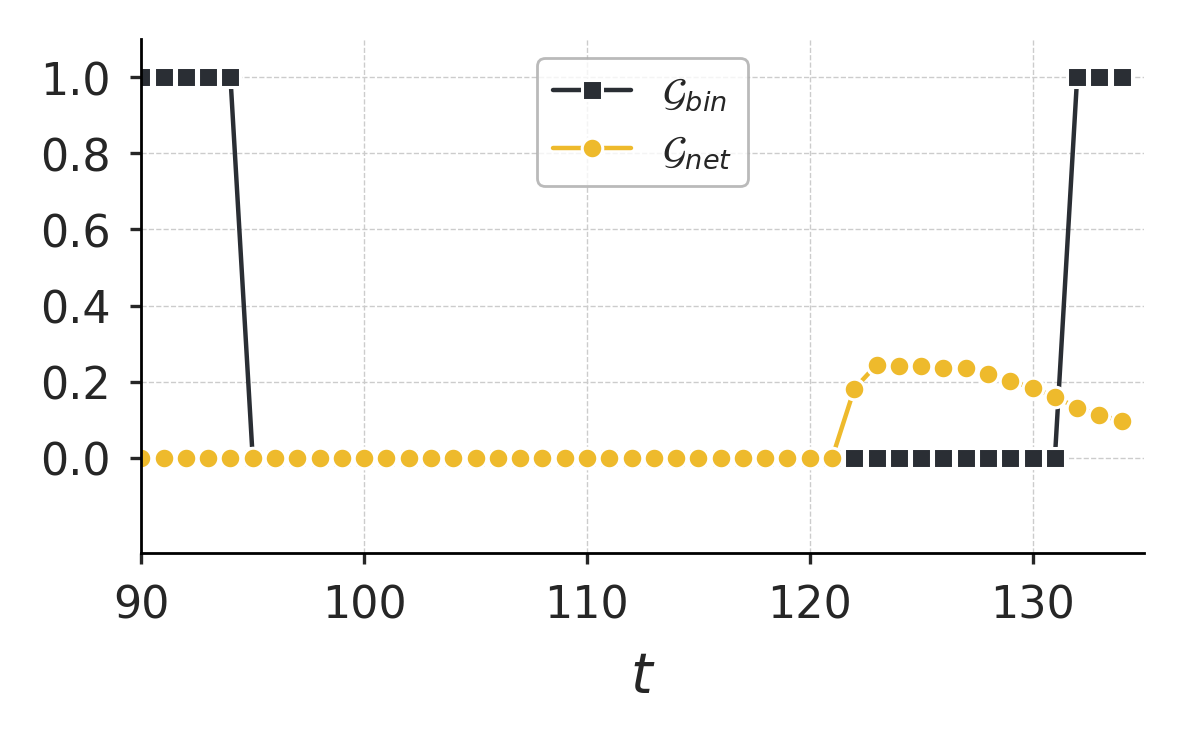

In [9]:
# Example usage:
fig, ax = plt.subplots(figsize=(3.3, 2.2), dpi = 400)
ax = plot_cherry_picking(ax, df_chi, df_chi_hat, df_gamma, row_of_interest, linewidth=0.8, markersize=3.7)
#set xaxis limits

plt.savefig(f"{out_plot_directory}/{num_agents}/cherryazzo.pdf", bbox_inches='tight')


plt.show()


In [11]:
%%script false --no-raise-error
#plot df_gamma, in black alone
fig, ax = plt.subplots(figsize=(3.3, 2.2), dpi = 400)

sns.lineplot(ax=ax, data=df_gamma[row_of_interest].reset_index(drop=True), legend=True,
                linewidth=1.8, dashes=False, marker="o", 
                color='black', markersize=5.7, markeredgewidth = 0.55)

# Remove right and top spines
sns.despine(ax=ax)

# Set grid alpha (reduce line thickness for smaller plot)
ax.grid(linestyle="--", linewidth=0.75)

#set xlim 
ax.set_xlim(110, len(df_gamma))

#remove y and x labels
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_xlabel(r"$t$", fontsize=20)
ax.set_ylabel(r"$\mathcal{G}_{net}$", fontsize=20)

#x and y axis in black
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')

#reduce x and y width
ax.spines['bottom'].set_linewidth(0.8)
ax.spines['left'].set_linewidth(0.8)



In [14]:
f"{out_plot_directory}/{num_agents}/cherryazzo.pdf"

'out/plots/centre_segr/4096/cherryazzo.pdf'

In [42]:
first_peak+18

141

In [43]:

def add_dataframes(df1, df2):
    merged_df = pd.merge(df1, df2, on=['source', 'pos'], how='outer', suffixes=('_first', '_second'))
    merged_df['flow_first'] = merged_df['flow_first'].fillna(0)
    merged_df['flow_second'] = merged_df['flow_second'].fillna(0)
    merged_df['flow'] = merged_df['flow_first'] + merged_df['flow_second']
    result_df = merged_df[['source', 'pos', 'flow']]
    return result_df

In [44]:
def get_graph_data(cell, step, delta, df_flow_C, df_flow_B, df_flow_A, df_cell_median):

    cell = eval(row_of_interest)
    step = step


    #in df_cell_median select only the rows where the index is step-delta
    df_cell_median_step = df_cell_median[(df_cell_median.index == step-delta)]
    cell_richnessess_beginningstep = dict(df_cell_median_step.iloc[0])


    cell_richnessess_beginningstep = {k:int(v) for k,v in cell_richnessess_beginningstep.items() if not math.isnan(v)}
    cell_richnessess_beginningstep_div = {k:v/100 for k,v in cell_richnessess_beginningstep.items()}



    #in df_flow_C, keep only the rows where the Step is in the range step-delta, step
    df_flow_C_step = df_flow_C[(df_flow_C["Step"] >= step - delta) & (df_flow_C["Step"] < step)]
    df_flow_B_step = df_flow_B[(df_flow_B["Step"] >= step - delta) & (df_flow_B["Step"] < step)]
    df_flow_A_step = df_flow_A[(df_flow_A["Step"] >= step - delta) & (df_flow_A["Step"] < step)]

    df_flow_Cout_step = df_flow_C_step[df_flow_C_step["source"] == cell]
    df_flow_Cin_step = df_flow_C_step[df_flow_C_step["pos"] == cell]

    df_flow_Bout_step = df_flow_B_step[df_flow_B_step["source"] == cell]
    df_flow_Bin_step = df_flow_B_step[df_flow_B_step["pos"] == cell]

    df_flow_Aout_step = df_flow_A_step[df_flow_A_step["source"] == cell]
    df_flow_Ain_step = df_flow_A_step[df_flow_A_step["pos"] == cell]



    #aggregate the flows with same source and pos
    weighted_edgelist_Cout_step = df_flow_Cout_step.groupby(["source", "pos"]).sum().reset_index().drop(columns = ["Step"])
    weighted_edgelist_Cin_step = df_flow_Cin_step.groupby(["source", "pos"]).sum().reset_index().drop(columns = ["Step"])

    weighted_edgelist_Bout_step = df_flow_Bout_step.groupby(["source", "pos"]).sum().reset_index().drop(columns = ["Step"])
    weighted_edgelist_Bin_step = df_flow_Bin_step.groupby(["source", "pos"]).sum().reset_index().drop(columns = ["Step"])

    weighted_edgelist_Aout_step = df_flow_Aout_step.groupby(["source", "pos"]).sum().reset_index().drop(columns = ["Step"])
    weighted_edgelist_Ain_step = df_flow_Ain_step.groupby(["source", "pos"]).sum().reset_index().drop(columns = ["Step"])


    weighted_edgelist_ABin_step = add_dataframes(weighted_edgelist_Ain_step, weighted_edgelist_Bin_step)



    return {"weighted_edgelist_Cout_step": weighted_edgelist_Cout_step,
            "weighted_edgelist_ABin_step": weighted_edgelist_ABin_step, 
            "cell_richnessess_beginningstep_div": cell_richnessess_beginningstep_div}

In [45]:
from numpy import size


def draw_graph(ax, weighted_edgelist, title, classe="C", focus="max", cell_richnessess_beginningstep=None):
    width = height = 7
    if focus == "max":
        focus_node = cell

    # Set grid and box settings
    ax.grid(alpha=0.5, linestyle="--", linewidth=0.3)  # Increased grid alpha for better visibility
    ax.set_frame_on(False)

    # Adjust axis limits and ensure grid covers all nodes
    ax.set_xlim(-0.5, width-1 + 0.5)  # Extend grid to full width
    ax.set_ylim(-0.5, height-1 + 0.5)  # Extend grid to full height
    ax.set_aspect('equal')  # Ensure aspect ratio remains equal for a square grid

    # Set ticks for every integer value
    ax.set_xticks(range(width))
    ax.set_yticks(range(height))
    ax.set_xticklabels([])
    ax.set_yticklabels([])

    data = weighted_edgelist

    # Create a directed graph
    G = nx.DiGraph()

    # Add all nodes based on the city grid dimensions
    for x in range(width):
        for y in range(height):
            G.add_node((x, y))

    # Add edges to the graph
    for entry in data:
        G.add_edge(entry['source'], entry['pos'], weight=entry['flow'])

    # Extract positions (nodes) from the data
    positions = {node: (node[1], height - 1 - node[0]) for node in G.nodes()}




    # Draw the nodes, scaling their size down to fit smaller figure size
    for node in G.nodes():
        color = 'black' if node == focus_node else 'grey'
        nx.draw_networkx_nodes(G, pos=positions, nodelist=[node],
                               node_size=cell_richnessess_beginningstep[node] / 20,
                               node_color=color, ax=ax, linewidths=0)  # Set linewidths to 0


    # Adjust edge drawing properties for smaller plot size
    edges = G.edges(data=True)
    for edge in edges:
        if classe == "B":
            nx.draw_networkx_edges(G, pos=positions, edgelist=[(edge[0], edge[1])],
                                width=edge[2]['weight'] / 5, edge_color="#5fbdb5",
                                arrows=True, arrowstyle='->', arrowsize=6,
                                connectionstyle='arc3,rad=0.35',
                                min_source_margin=0, min_target_margin=0,  # Reduced margins
                                ax=ax, alpha=1)
        elif classe == "C":
            nx.draw_networkx_edges(G, pos=positions, edgelist=[(edge[0], edge[1])],
                                width=edge[2]['weight'] / 5, edge_color="#f1938e",
                                min_source_margin=0, min_target_margin=0,  # Reduced margins
                                arrows=True, arrowstyle='->', arrowsize=6,
                                connectionstyle='arc3,rad=0.35',
                                ax=ax, alpha=1)


    # Set the title, adjusting font size to fit the smaller figure
    ax.set_title(title, fontsize=6, loc='left', fontweight='bold')

In [46]:
f"{out_plot_directory}/{num_agents}"

'out/plots/centre_segr/4096'

/tmp/ipykernel_3400488/2633943847.py:29: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


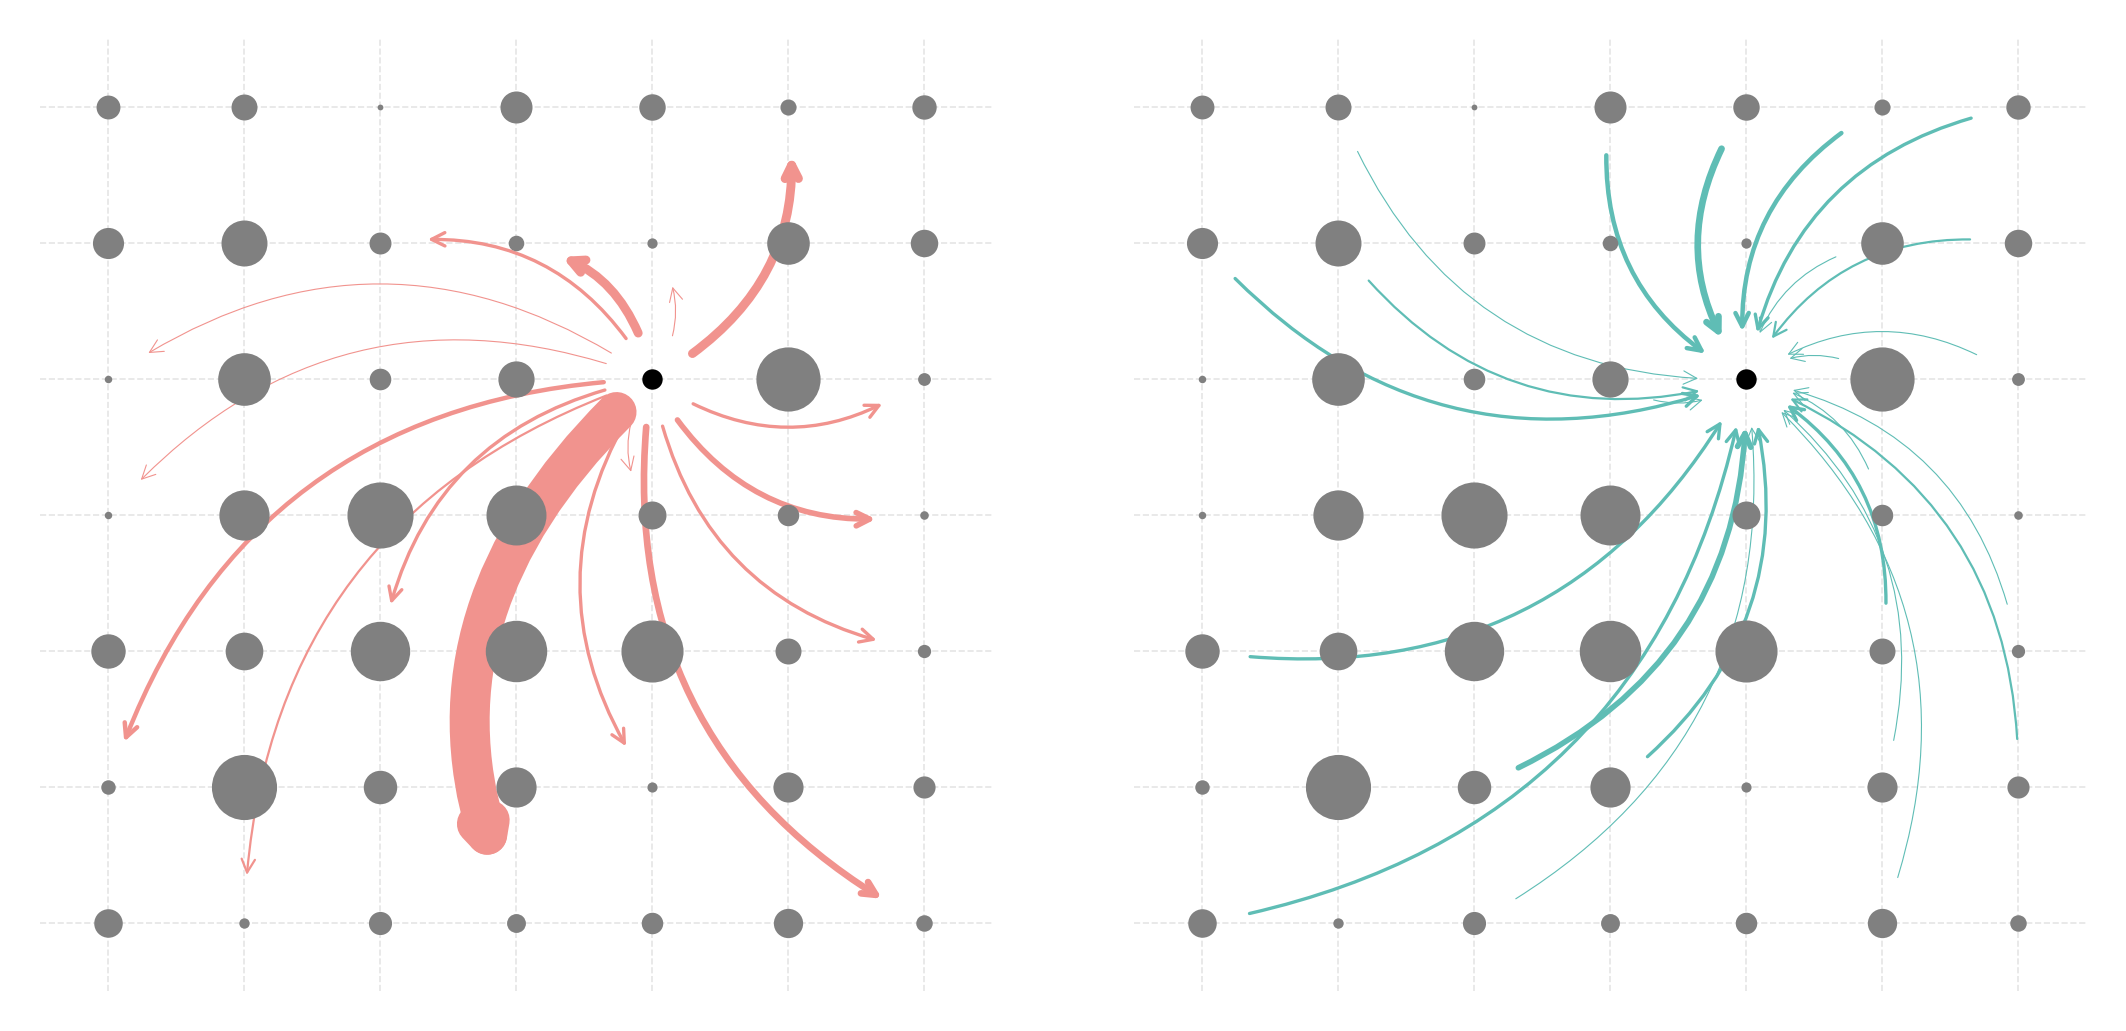

In [47]:
fig = plt.figure(figsize=(6.6, 3.3), dpi = 400)  # Adjusted height for better spacing
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1], wspace=0.15)


# Define your parameters
step = first_peak

# Get results
cell = eval(row_of_interest)
results = get_graph_data(cell, step, delta, df_flow_C, df_flow_B, df_flow_A, df_cell_median)
weighted_edgelist_Cout_step = results["weighted_edgelist_Cout_step"]
weighted_edgelist_Bin_step = results["weighted_edgelist_ABin_step"]

cell_richnessess_beginningstep_div = results["cell_richnessess_beginningstep_div"]


# Create subplots using gridspec
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])

# Draw first graph
draw_graph(ax1, weighted_edgelist_Cout_step.to_dict('records'), "", classe="C", focus="max",
            cell_richnessess_beginningstep=cell_richnessess_beginningstep_div)

# Draw second graph
draw_graph(ax2, weighted_edgelist_Bin_step.to_dict('records'),"", classe="B", focus="max",
            cell_richnessess_beginningstep=cell_richnessess_beginningstep_div)

plt.tight_layout()
plt.savefig(f"{out_plot_directory}/{num_agents}/during.pdf", bbox_inches='tight')
plt.show()

/tmp/ipykernel_3400488/1470399540.py:29: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


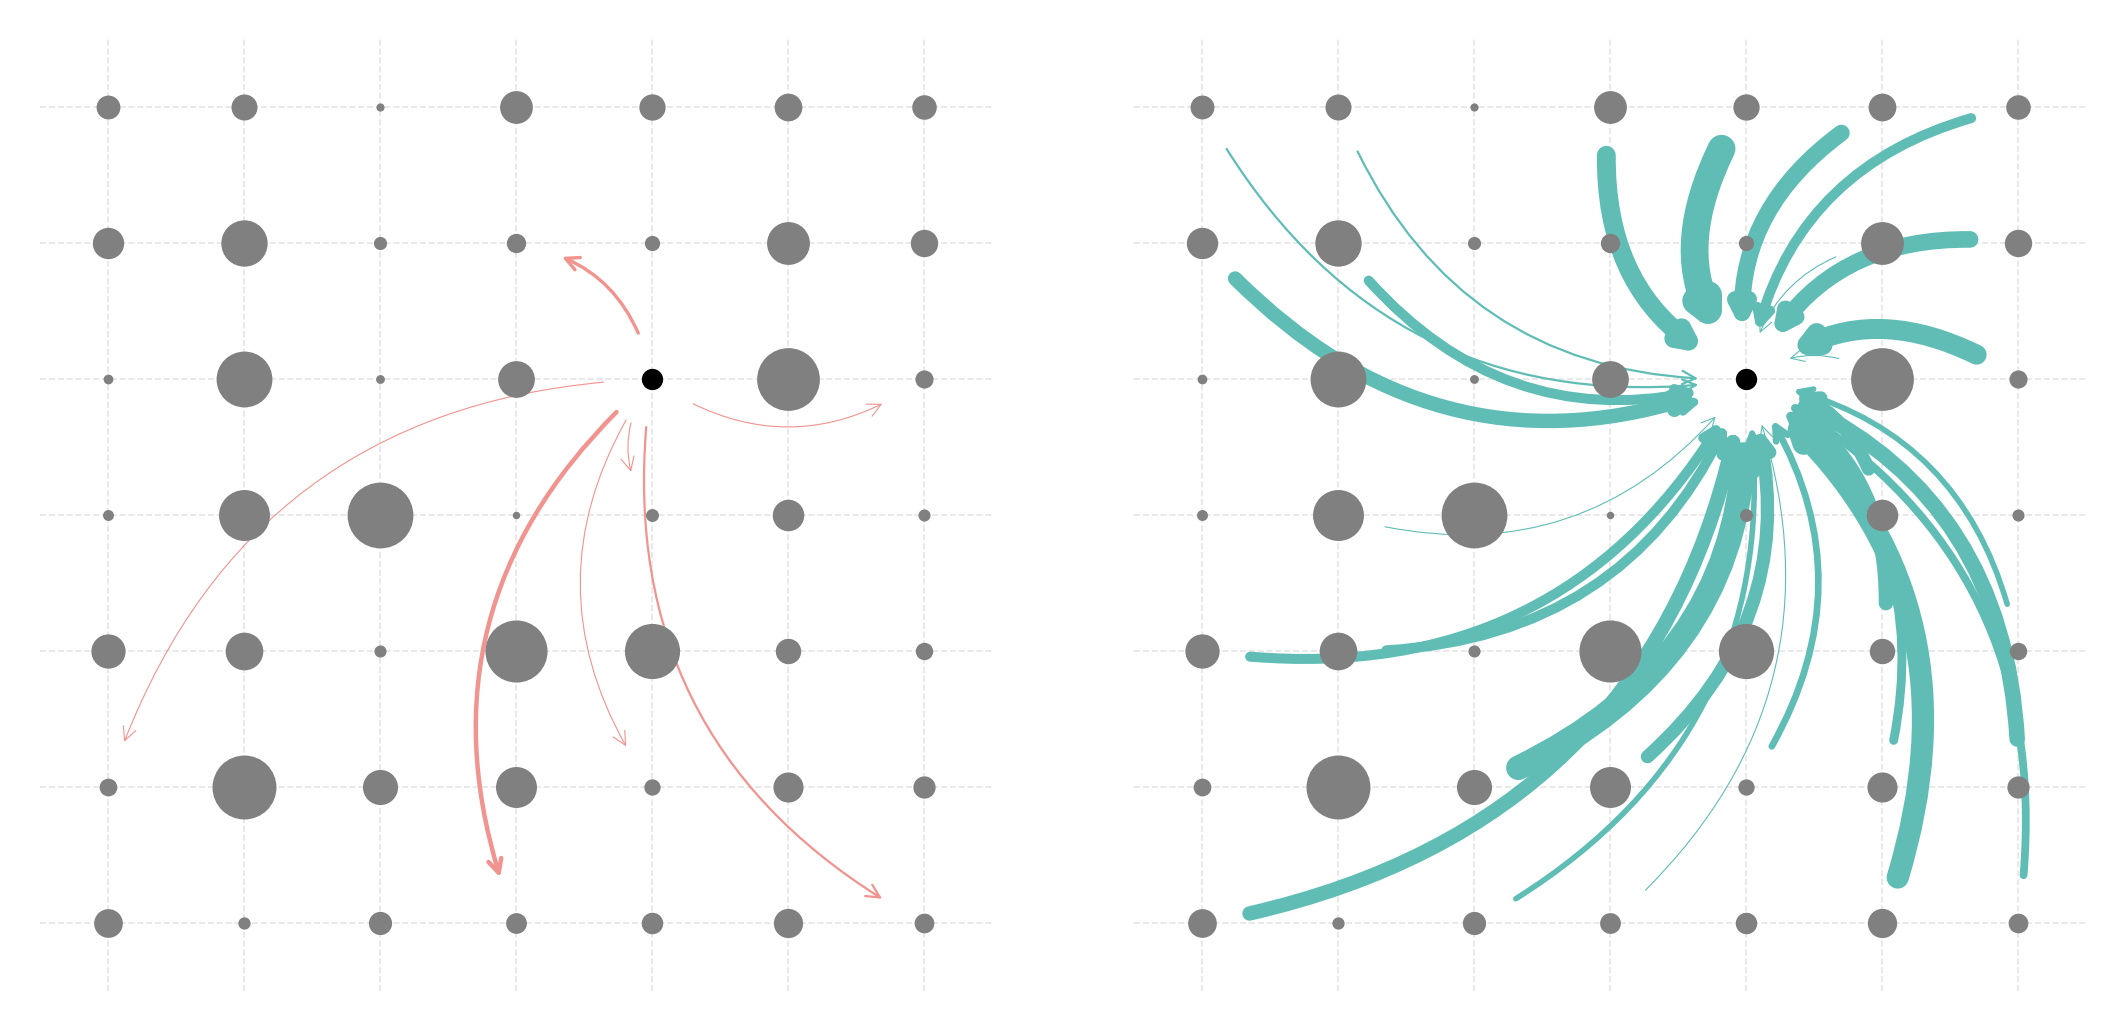

In [48]:
fig = plt.figure(figsize=(6.6, 3.3), dpi = 400)  # Adjusted height for better spacing
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1], wspace=0.15)


# Define your parameters
step = first_peak+8

# Get results
cell = eval(row_of_interest)
results = get_graph_data(cell, step, delta, df_flow_C, df_flow_B, df_flow_A, df_cell_median)
weighted_edgelist_Cout_step = results["weighted_edgelist_Cout_step"]
weighted_edgelist_Bin_step = results["weighted_edgelist_ABin_step"]

cell_richnessess_beginningstep_div = results["cell_richnessess_beginningstep_div"]


# Create subplots using gridspec
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])

# Draw first graph
draw_graph(ax1, weighted_edgelist_Cout_step.to_dict('records'), "", classe="C", focus="max",
            cell_richnessess_beginningstep=cell_richnessess_beginningstep_div)

# Draw second graph
draw_graph(ax2, weighted_edgelist_Bin_step.to_dict('records'),"", classe="B", focus="max",
            cell_richnessess_beginningstep=cell_richnessess_beginningstep_div)

plt.tight_layout()
plt.savefig(f"{out_plot_directory}/{num_agents}/post.pdf", bbox_inches='tight')
plt.show()

In [49]:
first_peak, step

(123, 131)